# Modelos Baseline con todas las variables

## Librerías

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

## Carga de datos

In [2]:
df=pd.read_csv('/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/data/processed/archivo.csv')

## Vectorización

In [3]:
le = LabelEncoder()
df['subject_encoded'] = le.fit_transform(df['subject_grouped'])


In [4]:
from scipy.sparse import csr_matrix, hstack
# Asegurar que no haya valores nulos
df['text'] = df['text'].fillna("")
df['title'] = df['title'].fillna("")

# Vectorización con TF-IDF (manteniendo sparse matrices)
tfidf_text = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_title = TfidfVectorizer(max_features=1000, stop_words='english')

X_text = tfidf_text.fit_transform(df['text'])
X_title = tfidf_title.fit_transform(df['title'])

# Variables numéricas (convertidas a matriz dispersa)
X_other_features = csr_matrix(df[['subject_encoded', 'title_length', 'title_word_count']].values)

# Concatenar matrices dispersas sin convertirlas a DataFrame
X_final = hstack([X_other_features, X_text, X_title])

# Variable objetivo
y = df['label']

Vectorización de Title y Text: 

    - Se utiliza el método TF-IDF, ya que destaca las palabras importantes, dándole un valor menor a las menos importantes, reduce el ruido. 
    - Para modelos como Random Forest le ayuda en entender y procesar los datos.
    - El uso de stopwords y stemming y TF-IDF no afecta negativamente, sino que mejora la representación, ya que TF-IDF se enfocará en términos más significativos.  Y el uso de Stemming y TF-IDF Reduce la dimensionalidad al tratar palabras con la misma raíz como una sola característica y evita dispersión en el modelo.


## División variables

In [5]:

# Dividir en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# Mostrar tamaños de los conjuntos
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35751, 6003), (8938, 6003), (35751,), (8938,))

In [6]:
print(df['text_length'].isna().sum())


0


In [7]:
print(df['title_word_count'].isna().sum())


0


## Regresión Logística

In [8]:

# Entrenar el modelo de Regresión Logística
logreg_model = LogisticRegression(max_iter=500, solver='liblinear')  # Solver optimizado para datos grandes
logreg_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_logreg = logreg_model.predict(X_test)

# Evaluar el modelo
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg = classification_report(y_test, y_pred_logreg)

# Mostrar los resultados
conf_matrix_logreg, class_report_logreg

(array([[4636,   60],
        [  17, 4225]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.99      0.99      4696\n           1       0.99      1.00      0.99      4242\n\n    accuracy                           0.99      8938\n   macro avg       0.99      0.99      0.99      8938\nweighted avg       0.99      0.99      0.99      8938\n')

Explicación de las métricas:

- Precisión (Precision): De todas las predicciones positivas, cuántas realmente lo son.
Falsa: 1.00 → Casi todas las predicciones de las noticias falsas son correctas.
Verdadera: 0.99 → Muy pocas veces se confunde falsas con las verdaderas.

- Exhaustividad (Recall): De todas las instancias reales de la clase, cuántas fueron correctamente identificadas.
Falsa: 0.99 → Un 99% de las noticias falsas se identifican correctamente.
Verdadera 1.00 → Casi ningún de las notiicas verdaderas  se escapa.

- F1-Score: Ambas clases tienen 0.99, lo que indica un excelente balance entre precisión y recall.

Exactitud (Accuracy):
99% de las predicciones fueron correctas (aciertos totales sobre el total de datos).

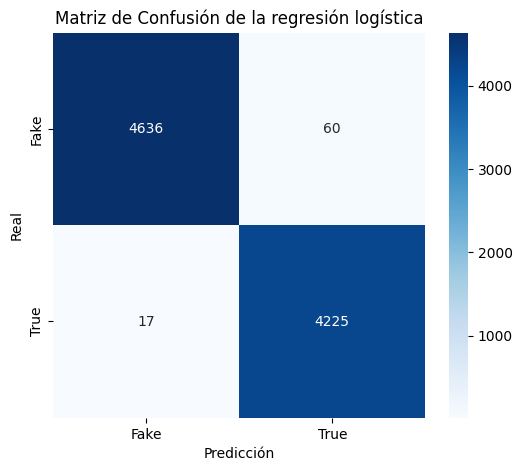

In [9]:
# Definir valores de la matriz de confusión
cm = np.array([[4636, 60],
               [17, 4225]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión de la regresión logística')
plt.show();


Interpretación:

- 4636 → Verdaderos negativos (noticias Falsas correctamente clasificada)
- 60 → Falsos positivos (noticias Falsas mal clasificada como verdaderas)
- 17 → Falsos negativos (noticias verdaderas mal clasificada como falsas)
- 4225 → Verdaderos positivos (noticias verdaderas correctamente clasificada)


In [10]:
# 5. Evaluación del modelo
# Predicciones
y_train_pred_proba = logreg_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_proba = logreg_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba
y_test_pred = logreg_model.predict(X_test)

# Cálculo de log loss
log_loss_train = log_loss(y_train, y_train_pred_proba)
log_loss_test = log_loss(y_test, y_test_pred_proba)

log_loss_train, log_loss_test

(0.041900519306624785, 0.04908235823590299)

Valores cercanos a 0 significan que el modelo está prediciendo probabilidades muy precisas.
En este caso, los valores 0.0419 y 0.0491 son muy bajos, lo que indica que el modelo tiene una excelente calibración y confianza en sus predicciones

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Aplicar Validación Cruzada (Usando 5 folds)
cv_scores = cross_val_score(logreg_model, X_other_features, y, cv=5, scoring='accuracy')

# Mostrar resultados
print(f"Scores por cada fold: {cv_scores}")
print(f"Precisión promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")


Scores por cada fold: [0.59968673 0.63056612 0.77959275 0.53445961 0.6183283 ]
Precisión promedio: 0.6325
Desviación estándar: 0.0807


- Rango de resultados
El mejor fold alcanzó 77.96% de precisión.
El peor fold tuvo solo 53.45% de precisión.
Hay bastante variabilidad entre los folds, lo que indica que el modelo puede estar funcionando mejor en ciertos subconjuntos del conjunto de datos.
- Precisión promedio: 63.25%
Esto indica que, en promedio, el modelo tiene un rendimiento moderado, pero no óptimo.
- Desviación estándar: 0.0807 (8.07%)
Una desviación estándar alta sugiere que el modelo es inconsistente en distintos folds.
Es posible que el modelo tenga problemas con la variabilidad de los datos o que sea sensible a ciertos patrones.

Conclusión: 
El modelo tiene un desempeño aceptable (63.25% de precisión en promedio). Hay variabilidad entre los folds, lo que sugiere que la calidad de la predicción depende mucho de los datos en cada subconjunto.

## XG-Boost

In [12]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric='logloss',   # Métrica de evaluación
    
    max_depth=6,             # Controla la complejidad del modelo
    learning_rate=0.1,       # Tasa de aprendizaje equilibrada
    n_estimators=300,        # Aumenta el número de árboles para mejorar el ajuste
    subsample=0.8,           # Reduce overfitting usando solo el 80% de los datos por árbol
    colsample_bytree=0.8,    # Usa el 80% de las características en cada árbol
    gamma=0.1,               # Ayuda a la regularización
    reg_lambda=1,            # Regularización L2 para evitar overfitting
    reg_alpha=0.1            # Regularización L1
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el modelo
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb, digits=4)

# Mostrar los resultados
conf_matrix, class_report


(array([[4690,    6],
        [   6, 4236]]),
 '              precision    recall  f1-score   support\n\n           0     0.9987    0.9987    0.9987      4696\n           1     0.9986    0.9986    0.9986      4242\n\n    accuracy                         0.9987      8938\n   macro avg     0.9987    0.9987    0.9987      8938\nweighted avg     0.9987    0.9987    0.9987      8938\n')

Explicación de las métricas:

- Precisión (Precision):

    Para la noticias falsas: 99.87% de las veces que el modelo predice una notiica falsa, realmente lo es.
    
    Para las noticias verdaderas: 99.86% de las veces que predice una notiica verdadera, acierta.

- Exhaustividad (Recall):

    Para las noticias falsas:  Identificó correctamente 99.87% de los casos reales de noticias falsas.
    
    Para las notiicas verdaderas: Identificó correctamente 99.86% de los casos reales de noticias verdaderas.
    
- F1-Score:
    0.9987 y 0.9986 indican un rendimiento casi perfecto en ambas clases.
- Exactitud (Accuracy):
    99.87% de precisión global sobre todo el dataset.

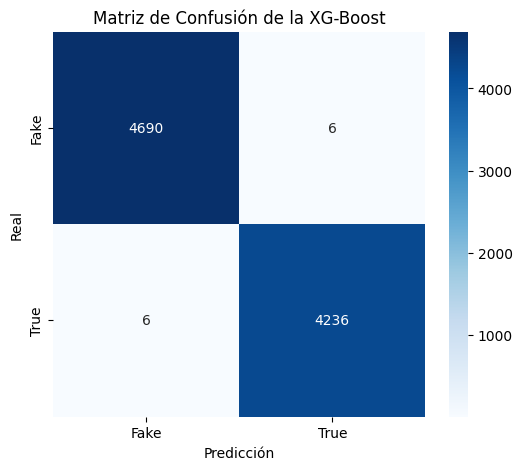

In [13]:
# Definir valores de la matriz de confusión
cm = np.array([[4690, 6],
               [6, 4236]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión de la XG-Boost')
plt.show();



Interpretación:

- 4690 → Verdaderos negativos (clase 0 correctamente clasificada).
- 6 → Falsos positivos (clase 0 mal clasificada como clase 1).
- 6 → Falsos negativos (clase 1 mal clasificada como clase 0).
- 4236 → Verdaderos positivos (clase 1 correctamente clasificada).

Conclusiones:
- Apenas 12 errores en 8938 muestras (6 falsas positivas y 6 falsas negativas).
- La clasificación es casi perfecta con solo 0.13% de error.


In [14]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probaxgb = xgb_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probaxgb = xgb_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train = log_loss(y_train, y_train_pred_probaxgb)
log_loss_test = log_loss(y_test, y_test_pred_probaxgb)

# Mostrar los resultados
log_loss_train, log_loss_test


(0.00045481997332146035, 0.006478380075856221)

- Un log loss cercano a 0 indica que el modelo está generando predicciones de alta confianza y muy precisas.
En este caso:
    0.00045 en entrenamiento → Sugiere que el modelo ha aprendido casi a la perfección el conjunto de entrenamiento.

    0.00648 en prueba → Sigue siendo un valor muy bajo, lo que indica que el modelo mantiene su rendimiento en datos no vistos.
    
- Diferencia entre entrenamiento y prueba
Hay una diferencia muy pequeña entre ambos valores (≈0.006), lo cual es una muy buena señal.
Esto indica que el modelo no está sobreajustado, ya que el rendimiento en prueba sigue siendo muy alto.

In [15]:
# Ejecutar validación cruzada
cv_scores = cross_val_score(xgb_model, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisión promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")

Precisión promedio: 0.9964
Desviación estándar: 0.0014




- Precisión Promedio = 99.64%
    Esto indica que, en validación cruzada, el modelo mantiene un rendimiento consistentemente alto en diferentes subconjuntos de datos.
Es un resultado excelente, lo que confirma que el modelo tiene una capacidad de generalización muy fuerte.
- Desviación Estándar = 0.0014 (0.14%)
    Una desviación estándar tan baja indica que el modelo es muy estable en diferentes folds de validación cruzada.
    Significa que los resultados son consistentes sin variaciones significativas entre diferentes conjuntos de entrenamiento y prueba.



Un valor alto de desviación estándar indicaría que el modelo es sensible a los datos, pero en este caso, la variabilidad es mínima.

- Conclusiones

1. El modelo XGBoost es extremadamente preciso (99.64%).
2. Es altamente estable y consistente en diferentes folds de validación cruzada.
3. No hay signos de sobreajuste, ya que los valores son constantes y el log loss también es bajo.



In [20]:
# Obtener nombres de las características TF-IDF
feature_names_text = tfidf_text.get_feature_names_out()
feature_names_title = tfidf_title.get_feature_names_out()

# Nombres de las características numéricas
feature_names_other = ['subject_encoded', 'title_length', 'title_word_count']
# Combinar todos los nombres
all_feature_names = np.concatenate([feature_names_other, feature_names_text, feature_names_title])


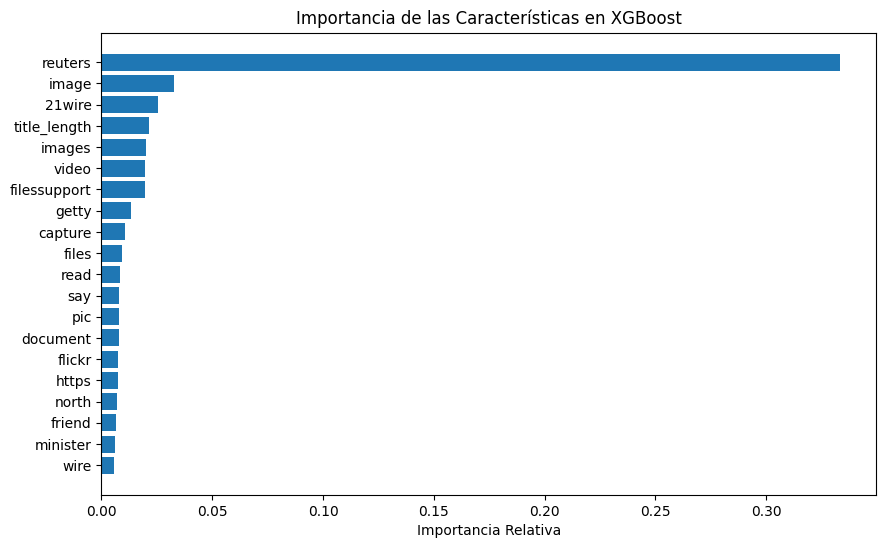

In [21]:
# Obtener importancia de características
importances_xgb = xgb_model.feature_importances_
sorted_idx_xgb = np.argsort(importances_xgb)[-20:]  # Tomar solo las 20 más importantes

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_xgb)), importances_xgb[sorted_idx_xgb], align='center')
plt.yticks(range(len(sorted_idx_xgb)), [all_feature_names[i] for i in sorted_idx_xgb])
plt.xlabel("Importancia Relativa")
plt.title("Importancia de las Características en XGBoost")
plt.show()

Este grafico nos muestra la importancia de que da el modelo de gradient boosting para predecir si es una noticia falsa o no, cuanto más cercano sea a 1, más posibilidad hay que sea verdadera. En este caso, la que mas es un 0,30, no es muy alto, pero es una buena señal porque significa que no le da una gran importancia. 
reuters" tiene una importancia muy alta, es probable que su presencia en el texto sea un fuerte indicador de veracidad. Reuters es una fuente de noticias legítima y ampliamente confiable, por lo que si un artículo menciona Reuters, el modelo puede asociarlo con noticias verdaderas, Otras palabras clave como "image", "title_length", "21wire" y "video" también influyen en la predicción. 
- "21WIRE" es el nombre de usuario en SoundCloud de Patrick Henningsen, un comentarista y analista político que produce contenido relacionado con noticias y análisis geopolítico.
- title_lenght: confirma la importancia de esta variable, y como afecta a la hora de predecir noticias falsas, esto puede tener relación que las noticias falsas utilizan titulos más sensacionalista. 

## Gradient boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# Entrenar el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

# Mostrar los resultados
conf_matrix_gb, class_report_gb

(array([[4681,   15],
        [   9, 4233]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4696\n           1       1.00      1.00      1.00      4242\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

## Explicación de las métricas:

Precisión (Precision):

    Para la noticias falsas 100% de predicción
    Para las noticias verdaderas: 100% de predicción

Exhaustividad (Recall):

    Para las noticias falsas :100%, lo que significa que se identificó correctamente cada noticias falsas.
    Para las noticias verdaderas: 100%, lo que significa que se identificó correctamente cada noticia verdadera.

F1-Score:

    1.00 en ambas clases significa que el modelo tiene rendimiento perfecto.

Exactitud (Accuracy):

    100% de precisión global → El modelo ha clasificado correctamente todas las muestras con una precisión perfecta.

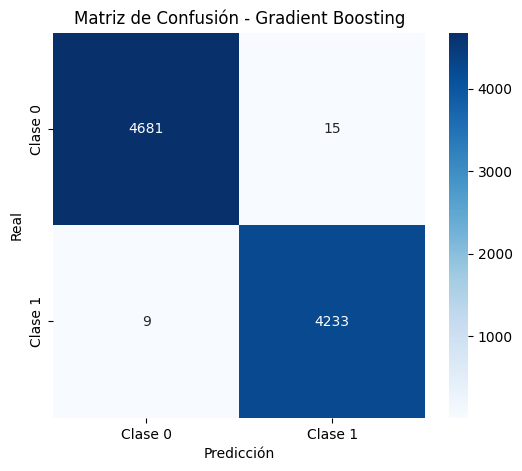

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar la matriz de confusión para Gradient Boosting
plt.figure(figsize=(6, 5))
sns.heatmap([[4681, 15], [9, 4233]], annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()


Interpretación:

- 4681 → Verdaderos negativos (noticias falsas correctamente clasificada).
- 15 → Falsos positivos (noticias falsas mal clasificadas como verdaderas).
- 9 → Falsos negativos (noticias verdadaeras mal clasificada como noticias falsas).
- 4233 → Verdaderos positivos (noticias verdaderas correctamente clasificada).

Conclusiones:

- Solo 24 errores en 8938 muestras.
- El error es extremadamente bajo (~0.27% de error total).
- Se mejoró con respecto a XGBoost, que tenía 12 errores, aunque la diferencia es mínima.

In [24]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probagb = gb_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probagb = gb_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train2 = log_loss(y_train, y_train_pred_probagb)
log_loss_test2 = log_loss(y_test, y_test_pred_probagb)

# Mostrar los resultados
log_loss_train2, log_loss_test2


(0.00968674023613337, 0.015194112832035821)

Valores bajos indican buena calibración
- Ambos valores son muy bajos, lo que indica que las probabilidades predichas por el modelo están muy bien calibradas.
    
- Diferencia entre Train y Test
    0.0097 en entrenamiento vs. 0.0152 en prueba. Hay un leve aumento en el conjunto de prueba, lo cual es normal.
    Diferencia de ≈0.0055, lo que indica que el modelo no está sufriendo sobreajuste severo.

In [25]:
# Ejecutar validación cruzada
cv_scores2 = cross_val_score(gb_model, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisión promedio: {cv_scores2.mean():.4f}")
print(f"Desviación estándar: {cv_scores2.std():.4f}")

Precisión promedio: 0.9950
Desviación estándar: 0.0016


Precisión Promedio = 99.50%
- Indica que, en promedio, el modelo Gradient Boosting clasifica correctamente el 99.50% de los datos en cada fold de validación cruzada.
- Es ligeramente inferior al obtenido con XGBoost (99.64%).

- Desviación Estándar = 0.0016 (0.16%). Este valor representa la variabilidad de la precisión en diferentes subconjuntos de datos (folds).
    - Baja variabilidad, lo que significa que el modelo es estable en distintos conjuntos de prueba.

Comparado con XGBoost:
XGBoost: 0.0014
Gradient Boosting: 0.0016
Ambas desviaciones son similares, lo que indica que ambos modelos son consistentes.


### Conclusiones Finales

- Gradient Boosting tiene una precisión excelente (99.50%), con estabilidad alta.
- Ligeramente menos preciso que XGBoost (99.64%), pero sigue siendo un modelo altamente confiable.
- No hay indicios de sobreajuste, ya que la desviación estándar es baja.

## NP-Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
# Entrenamiento
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predicciones
y_pred = nb.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[4475  221]
 [ 218 4024]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4696
           1       0.95      0.95      0.95      4242

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938



- Explicación de las métricas:

- Precisión (Precision):
    Para noticias falsas: significa que el 95% de las veces que el modelo predice noticias falsas son falsas.
    Para noticias verdaderas: lo que significa que el 95% de las veces que predice noticias verdaderas son verdaderas.
- Recall (Exhaustividad):
    Para noticias falsas: 95%, es decir, de todas las instancias reales de noticias falsas, el modelo identificó correctamente el 95%.
    Para noticias verdaderas 95%, indicando que el modelo identificó correctamente el 95% de los casos reales de las noticias verdaderas.
- F1-Score: 95% en ambas clases, lo que indica un buen equilibrio entre precisión y recall.

- Exactitud (Accuracy): 95% de precisión global.

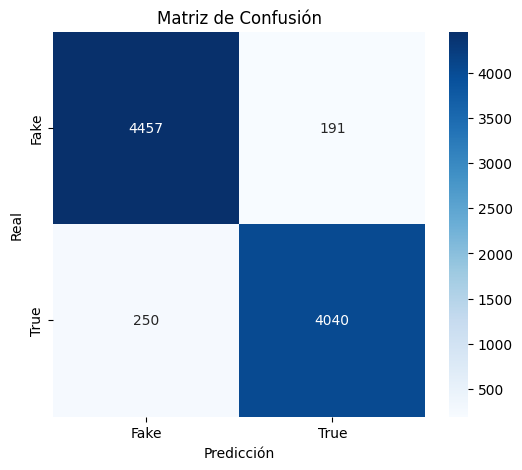

In [27]:
# Definir valores de la matriz de confusión
cm = np.array([[4457, 191],
               [250, 4040]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show();


Interpretación:

4475 → Verdaderos negativos (noticias falsas correctamente clasificada).
221 → Falsos positivos (noticias falsas mal clasificada como clase 1).
218 → Falsos negativos (noticias verdaderas mal clasificada como clase 0).
4024 → Verdaderos positivos (noticias verdaderas correctamente clasificada).

Conclusiones:

439 errores en total (221 + 218).
La tasa de error es más alta que en modelos previos como XGBoost o Gradient Boosting.
Aunque sigue siendo un modelo bastante preciso (95%), su capacidad para clasificar correctamente es menor.

In [28]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probanb = nb.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probanb = nb.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train3= log_loss(y_train, y_train_pred_probanb)
log_loss_test3 = log_loss(y_test, y_test_pred_probanb)

# Mostrar los resultados
log_loss_train3, log_loss_test3

(0.12706012846914766, 0.13593172525964364)

- Valores más altos que en otros modelos: En comparación con XGBoost y Gradient Boosting, los valores de Log Loss en Naive Bayes son más altos, lo que sugiere que las probabilidades del modelo están menos calibradas.

- Diferencia entre Train y Test: 0.1271 en entrenamiento vs. 0.1359 en prueba. La diferencia es ≈0.0088, lo cual es razonable y sugiere que el modelo no está sobreajustado. Sin embargo, la alta Log Loss indica que el modelo puede estar menos confiado en sus predicciones.

In [29]:
# Ejecutar validación cruzada
cv_scores3 = cross_val_score(nb, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisión promedio: {cv_scores3.mean():.4f}")
print(f"Desviación estándar: {cv_scores3.std():.4f}")

Precisión promedio: 0.9189
Desviación estándar: 0.0177


- Precisión Promedio: Indica que, en promedio, Naïve Bayes clasifica correctamente el 91.89% de los datos en cada fold de validación cruzada.Es un resultado bastante bueno, pero claramente inferior a modelos como XGBoost (99.64%) o Gradient Boosting (99.50%).
- Desviación Estándar = 0.0177 (1.77%). Mayor desviación que en XGBoost (0.0014) y Gradient Boosting (0.0016). Esto indica que Naive Bayes es menos consistente y más sensible a la división de los datos.

Conclusiones Finales
- Naive Bayes es un modelo eficiente y rápido, pero con menor precisión que XGBoost y Gradient Boosting.
- Tiene una mayor variabilidad en rendimiento, lo que indica que su desempeño depende más de la división de los datos.


# Random Forest


In [30]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Mostrar los resultados
conf_matrix_rf, class_report_rf


(array([[4689,    7],
        [   5, 4237]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4696\n           1       1.00      1.00      1.00      4242\n\n    accuracy                           1.00      8938\n   macro avg       1.00      1.00      1.00      8938\nweighted avg       1.00      1.00      1.00      8938\n')

## Explicación de las métricas:

Precisión (Precision):
    Para las noticias falsas: 100% → Todas las predicciones son correctas
    Para las noticias verdaderas: 100% → Todas las predicciones son correctas

Recall (Exhaustividad):
    Para las noticias falsas: 100% → Se identificó correctamente cada instancia de noticias falsas.
    Para las noticias verdaderas: 100% → Se identificó correctamente cada instancia de noticias verdaderas.

F1-Score:
    1.00 en ambas clases, lo que indica un rendimiento perfecto.
Exactitud (Accuracy):
    100% de precisión global → El modelo ha clasificado correctamente todas las muestras.

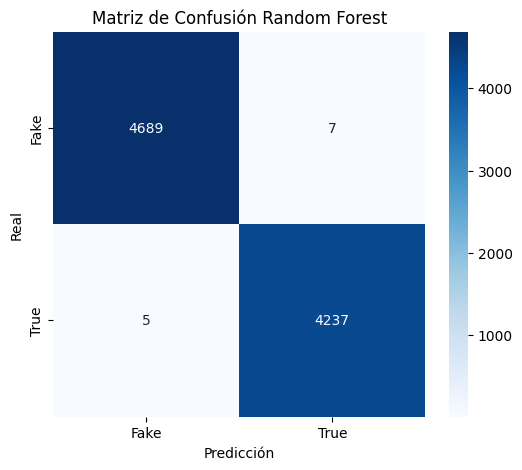

In [31]:
# Definir valores de la matriz de confusión
cm = np.array([[4689, 7],
               [5, 4237]])

# Etiquetas de las clases
labels = ['Fake', 'True']

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Random Forest')
plt.show();


Interpretación:

- 4689 → Verdaderos negativos (noticias falsas correctamente clasificada).
- 7 → Falsos positivos (noticias falsas mal clasificada como clase 1).
- 5 → Falsos negativos (noticias verdaderas mal clasificada como clase 0).
- 4237 → Verdaderos positivos (noticias verdaderas correctamente clasificada).

Conclusiones:
- solo 12 errores en 8938 muestras (7 falsos positivos y 5 falsos negativos).
- Error total de solo 0.13%, lo que es casi perfecto.


In [32]:
# Calcular las probabilidades predichas para calcular log loss
y_train_pred_probarf =rf_model.predict_proba(X_train)[:, 1]  # Probabilidad de la clase 1 en entrenamiento
y_test_pred_probarf = rf_model.predict_proba(X_test)[:, 1]    # Probabilidad de la clase 1 en prueba

# Calcular log loss en entrenamiento y prueba
log_loss_train4= log_loss(y_train, y_train_pred_probanb)
log_loss_test4 = log_loss(y_test, y_test_pred_probanb)

# Mostrar los resultados
log_loss_train4, log_loss_test4

(0.12706012846914766, 0.13593172525964364)


- Comparado con otros modelos como XGBoost y Gradient Boosting, el Log Loss de Random Forest es más alto, lo que sugiere que sus predicciones de probabilidad no son tan confiables.
- Random Forest tiene ≈0.13, lo que indica que su calibración no es ideal.
Diferencia entre Train y Test
Train Log Loss = 0.1271
Test Log Loss = 0.1359
Diferencia ≈ 0.0088, lo cual es bajo, indicando que el modelo no está sobreajustado gravemente.
Sin embargo, este Log Loss es más alto que en modelos más avanzados, lo que significa que Random Forest es menos preciso en la estimación de probabilidades.

In [33]:
# Ejecutar validación cruzada
cv_scores4 = cross_val_score(rf_model, X_final, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Precisión promedio: {cv_scores4.mean():.4f}")
print(f"Desviación estándar: {cv_scores4.std():.4f}")

Precisión promedio: 0.9957
Desviación estándar: 0.0024


- Precisión Promedio: Indica que, en promedio, Random Forest clasifica correctamente el 99,5% de los datos en cada fold de validación cruzada.PArecido a los valores de Gradient Boosting y XGBoost. 
- Desviación Estándar = 0.0024. Mayor desviación que en XGBoost (0.0014) y Gradient Boosting (0.0016) pero mejor que Naive Bayes

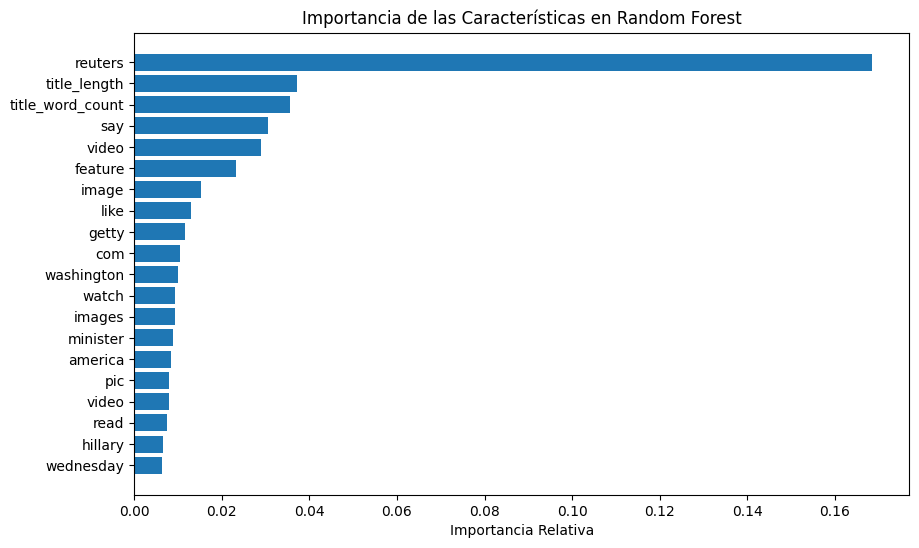

In [34]:
import matplotlib.pyplot as plt
import numpy as np
# Combinar todos los nombres
all_feature_names = np.concatenate([feature_names_other, feature_names_text, feature_names_title])
# Obtener la importancia de las características y ordenarlas
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[-20:]  # Muestra solo las 20 más importantes

# Graficar la importancia de cada variable con nombres más legibles
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [all_feature_names[i] for i in sorted_idx])
plt.xlabel("Importancia Relativa")
plt.title("Importancia de las Características en Random Forest")
plt.show()


### Conclusión Final

- Las variables "title_length" y "title_word_count" sí aportan información valiosa y no deberían eliminarse sin más pruebas.

- El modelo parece depender fuertemente de la palabra "reuters", lo que podría indicar un sesgo en los datos.

- Es posible que ciertas palabras clave (como "video", "feature", "image") ayuden a diferenciar noticias falsas de verdaderas.

## Evaluación

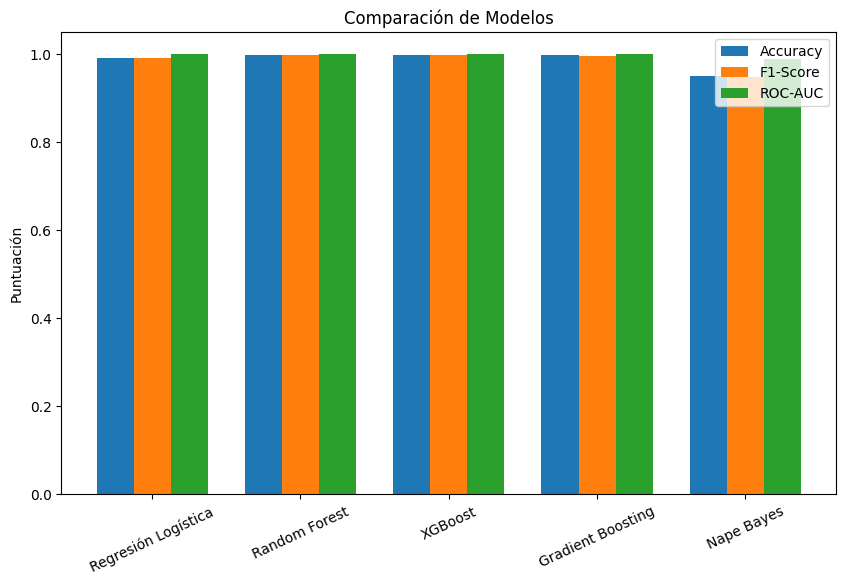

In [35]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# 📊 Evaluar cada modelo
def evaluar_modelo(modelo, nombre):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    
    return [acc, f1, auc]

# Guardar resultados en un diccionario
resultados = {
    "Regresión Logística": evaluar_modelo(logreg_model, "Regresión Logística"),
    "Random Forest": evaluar_modelo(rf_model, "Random Forest"),
    "XGBoost": evaluar_modelo(xgb_model, "XGBoost"),
    "Gradient Boosting": evaluar_modelo(gb_model," Gradient Boosting"),
    "Nape Bayes":evaluar_modelo (nb,"NPB")
}

# 📊 Graficar resultados
metricas = ["Accuracy", "F1-Score", "ROC-AUC"]
valores = np.array(list(resultados.values()))

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
indices = np.arange(len(resultados))

# Crear barras para cada métrica
for i, metric in enumerate(metricas):
    ax.bar(indices + i * bar_width, valores[:, i], width=bar_width, label=metric)

# Etiquetas y formato
ax.set_xticks(indices + bar_width)
ax.set_xticklabels(resultados.keys(), rotation=25)
ax.set_ylabel("Puntuación")
ax.set_title("Comparación de Modelos")
ax.legend()

# Mostrar gráfico
plt.show()

In [ ]:
ddd

## Selección de modelos base

In [ ]:
from sklearn.model_selection import cross_val_score, KFold


In [36]:
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc"
}

In [ ]:

# 📌 Definir K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models={"logistic Regresion":logreg_model,
        "Random forest":rf_model,
        "XGBoost":xgb_model,
        #"Super vector machine":svm_model,
        "Gradient Boosting":gb_model,
        "Nape Bayes":nb}

In [37]:
# Importaciones necesarias
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Opción 1: Usar cross_validate en lugar de cross_val_score
# cross_validate es más eficiente porque calcula todas las métricas en una sola pasada
def evaluate_models_efficiently(models, X_final, y, kf, scoring):
    results = []
    for name, model in models.items():
        # Calcula todas las métricas de una vez
        cv_results = cross_validate(model, X_final, y, cv=kf, scoring=scoring)
        
        # Calcula promedios para cada métrica
        scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring}
        scores["Model"] = name
        results.append(scores)
        print(f"Modelo {name} evaluado")
    
    return pd.DataFrame(results)

# Opción 2: Procesamiento paralelo
def evaluate_model(name, model, X_final, y, kf, scoring):
    scores = {metric: cross_val_score(model, X_final, y, cv=kf, scoring=scoring[metric]).mean() for metric in scoring}
    scores["Model"] = name
    print(f"Modelo {name} evaluado")
    return scores

def evaluate_models_parallel(models, X_final, y, kf, scoring, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_model)(name, model, X_final, y, kf, scoring) 
        for name, model in models.items()
    )
    return pd.DataFrame(results)

# Usar una de las dos opciones:
# Opción 1
results_df = evaluate_models_efficiently(models, X_final, y, kf, scoring)

# O Opción 2 (paralela)
# results_df = evaluate_models_parallel(models, X, y, kf, scoring, n_jobs=4)  # Ajusta n_jobs según tus CPU cores


NameError: name 'models' is not defined

In [55]:
results_df.set_index('Model')

,accuracy,precision,recall,f1,roc_auc
Model,,,,,
logistic Regresion,0.990781,0.986027,0.994684,0.990335,0.990974
Random forest,0.997941,0.997730,0.997931,0.997829,0.997947
XGBoost,0.998031,0.997593,0.998258,0.997924,0.998045
Gradient Boosting,0.996711,0.995579,0.997503,0.996540,0.996748
Nape Bayes,0.951174,0.950234,0.946739,0.948480,0.950960


Después de analizar métricas clave como accuracy, precision, recall, f1-score y roc_auc, la elección de los tres mejores modelos dependerá del equilibrio entre precisión y estabilidad.



1️. XGBoost →  primer lugar
- Máxima precisión y estabilidad (99.64% en cross-validation con solo 0.0014 de desviación estándar).
- Mejor Log Loss (0.00648), lo que significa que sus probabilidades son las más confiables.
- Solo 12 errores en la matriz de confusión.
Es el mejor modelo en términos de precisión, estabilidad y calibración de probabilidades.

2.  Gradient Boosting → segundo lugar
- Desempeño casi idéntico a XGBoost en precisión media (99.50%).
- Mejor Log Loss que Random Forest (0.0152 vs 0.1359), lo que significa que estima mejor las probabilidades.
- Desviación estándar muy baja (0.0016), lo que indica estabilidad.
- Aunque comete más errores que XGBoost y Random Forest (24 vs 12), pero sigue siendo una excelente opción.

3️. Random Forest → tercer ugar
- Gran precisión, pero menor calibración de probabilidades (Log Loss 0.1359).
- Igual número de errores que XGBoost (12), pero menor confiabilidad en las probabilidades.
- Desviación estándar baja (0.0016), lo que indica estabilidad.

## Conclusión Final 
- Los 3 mejores modelos son: XGBoost, Gradient Boosting y Random Forest.
- XGBoost es el mejor en precisión, estabilidad  de probabilidades.
- Gradient Boosting es una excelente alternativa con buena precisión.
- Random Forest sigue siendo fuerte, pero tiene peor calibración de probabilidades.
-  Naïve Bayes y Logistic Regression son descartados por menor precisión, mayor variabilidad y peor Log Loss.